# CS 224, Fall 2021
## Problem Set 3

## **DUE SUNDAY, December 5, 2021 @ 11:59pm PDT **

<div class="alert alert-info">
    <b>Complete with your Information</b><br>
    <i>By Submitting this notebook, I assert that all of the work presented here is my own and performed for the express sole purpose of this offering of this course.</i><br>
        <br>
      <b>(full) Name:</b>  Your Name Here  <br>
    <b>Student ID Number:</b> Your SIN Here
</div>

<div class="alert alert-success">
    <font size=+2>Total Problem Set Grading</font> (to be completed by grader)<br>
    Total Points: /15<br>
    Late Days Used on this Assignment: <br>
    Total Late Days Used: <br>
</div>

## Problem Set Structure

The first part of this problem set is about using a Gaussian mixture model on the Ames housing data.

The second part of this problem set is about using a Markov model (not a hidden Markov model) to model English text.

The two are unrelated.

## Part 1 Preliminaries

We will again be using the data on house sales in Ames, Iowa for the first part of this assignment.  Data documentation can be found at http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

The code block below again loads in the data.  However, this time we will only be using 7 features (to make the results more easily plotted). 

**Do NOT adjust** this code.  Further, you **may not add additional imports** to this notebook.

The resulting variables are (again) slightly different this time:
 - `X`: the data, shape (m,n): m examples, each with n features
 - `featurenames`: the semantic names of the features (you don't really need to worry about this one)

In [5]:
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 150 # this and above will make the figures large enough to read
def loadamesdata(n):
    import pandas as pd
    
    dataframe = pd.read_table('AmesHousing.txt',delimiter='\t')

    dataframe = dataframe[dataframe['Gr Liv Area']<4000] # remove the five really large houses
    dataframe = dataframe[dataframe['Sale Condition']=='Normal'] # don't consider partial sales or other types of abnormal sales
    dataframe = dataframe.drop(columns=['Order','PID','Sale Condition'])
    dataframe = dataframe.drop(columns=['Garage Cars','Full Bath']) # not really continuous and mess up clustering

    categorynames = []
    iscat = []
    dataframe = dataframe.drop(columns=[c for c in dataframe if dataframe[c].dtype.name=='object' or c=='MS SubClass'])
    dataframe.dropna(inplace=True)
    cor = dataframe.corr()
    ftouse = cor['SalePrice'].abs().sort_values(ascending=False)[:n].index
    dataframe = dataframe[ftouse]
    return dataframe.to_numpy(),dataframe.columns

X,featurenames = loadamesdata(7)

### Data Normalization

First, we are going to "standardize" or "normalize" each input feature.  Consider that the square footage for living area is not really 
comparable with the year built or the number of kitchens.  To put these different features "on the same scale," we will divide each by
its standard deviation.

There is no principled reason to expect this to have a useful effect.  However, in practice, this works very well as an initial normalizing
step and is fairly universal.

After you have completed the assignment, you may try commenting out the code below and rerunning to see the difference.  It is instructive.  However, please
submit with this code block active.

In [6]:
stddevs = np.std(X,axis=0)+1e-6
X /= stddevs

<div class="alert alert-warning">
    <font size=+2>Question 1</font><br>
    <font size=+1>4 points</font>
</div>

<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /4<br>
</div>

Write code to fit a Gaussian mixture model (with full covariance matrices) to the data in `X`.  You should use the expectation-maximization (EM) algorithm.  A few further specifications:
 - Initialize your parameters as follows:
   - set the pis to all start at 1/K
   - set the means to be at K different, randomly chosen, data points.  It might help to know that to pick 5 numbers from 1 to 10, without replacement, you can
      ```python
      rng = np.random.default_rng()
      rng.choice(10,5,replace=False)
      ```
   - set the Sigmas to the identity matrix (this is reasonable because the data have been normalized as above)
 - When calculating the new Sigmas, you matrix may become singular if you just use the formula from class.  Therefore, you should instead
   use $\Sigma_k = \left(\frac{B_k}{m_k} - \mu_k\mu_k^T\right)(1-\alpha) + \alpha I$.  This adds in a bit of the identity matrix to regularize
   the solution.  For this problem let $\alpha = 0.0001$.
   
   Note that this means that the log-likelihood *might* (but probably won't) descrease after an iteration.  If so, it wouldn't be by very much at all, so if your log-likelihood is decreasing, there is probably a mistake in your code.
 - You code should calculate the log-likelihood of the data at each step.  It should return the sequence of log-likelihoods (one per iteration of EM) as well as the final parameters.



In [7]:
# Your code here.  I recommend breaking up your code into logical small pieces, each their own function.
alpha = 0.0001
from scipy.stats import multivariate_normal
def pdf_multivariate_gauss(x, mu, sigma, N):
    # print(np.linalg.det(cov))
    p0 = np.linalg.det(sigma)**(1/2)
    p1 = 1 / ( ((2* np.pi)**(N/2)) * p0 )
    p2 = (x.T-mu)
    p3 = np.linalg.inv(sigma)
    p4 = (-1/2) * p2.T@p3@p2
    pdf = p1 * np.exp(p4)
    return pdf

def EM(K, I):
    #initialization
    m = X.shape[0]
    pis = []
    means = []
    sigmas = []
    for i in range(K):
        pis.append(1/K)
        sigmas.append(np.identity(X.shape[1], dtype=np.float64))
    rng = np.random.default_rng()
    rngs = rng.choice(m,K,replace=False)
    for i in rngs:
        means.append(X[i])
    pis = np.array(pis)
    means = np.array(means)
    sigmas = np.array(sigmas)
    
    #iterations
    for _ in range(I):
        llh = 0
        for i in range(m):
            sum_pmg = 0
            for k in range(K):
                sum_pmg += pis[k]*multivariate_normal.pdf(X[i],means[k],sigmas[k])

            llh += np.log(sum_pmg)
        # print(llh)
        t = 0
        for k in range(K):
            rik = 0
            rik_Xi = 0
            rik_XiXiT = 0
            for i in range(m):
                rik += ( pis[k]*multivariate_normal.pdf(X[i],means[k],sigmas[k]) )/sum_pmg
                rik_Xi += rik*X[i]
                rik_XiXiT += rik*(X[i]@X[i].T)

            pis[k] = rik/m
            means[k] = rik_Xi/rik
            sigmas[k] = ( ( (rik_XiXiT/rik) - (means[k]@means[k].T)*(1-alpha) ) + alpha*np.identity(X.shape[1]) )
            # print(sigmas[k])
            
EM(3,5)

ValueError: the input matrix must be positive semidefinite

In [8]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)

def get_likelihood(clusters):
    sample_likelihoods = np.log(np.array([cluster['gamma_total'] for cluster in clusters]))
    return np.sum(sample_likelihoods)

def GMM(K,I):
    m = X.shape[0]
    clusters = []
    llh_list = []
    rng = np.random.default_rng()
    rngs = rng.choice(m,K,replace=False)

    for j in rngs:
        clusters.append({
            'pi_k': 1.0 / K,
            'mu_k': X[j],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })

    for _ in range(I):
        gamma_total = np.zeros((X.shape[0], 1), dtype=np.float64)
        
        for cluster in clusters:
            pi_k = cluster['pi_k']
            mu_k = cluster['mu_k']
            cov_k = cluster['cov_k']
            
            gamma_nk = (pi_k * gaussian(X, mu_k, cov_k)).astype(np.float64)
            cluster['gamma_nk'] = gamma_nk
        
        for cluster in clusters:
            gamma_total += cluster['gamma_nk']

        for cluster in clusters:
            cluster['gamma_total'] = gamma_total
        
        for cluster in clusters:
            cluster['gamma_nk'] = cluster['gamma_nk']/cluster['gamma_total']
        
        llh_list.append(get_likelihood(clusters))
        #M  step
        m = float(X.shape[0])
  
        for cluster in clusters:
            r_ik = cluster['gamma_nk']
            b_k = np.zeros((X.shape[1], X.shape[1]), dtype=np.float64)
            
            m_k = np.sum(r_ik, axis=0)
            
            pi_k = m_k / m
            a_k = np.sum(r_ik * X, axis=0)
            mu_k = a_k/m_k

            for j in range(X.shape[0]):
                diff = (X[j] - mu_k).reshape(-1, 1)
                b_k += r_ik[j] * np.dot(diff, diff.T)

            cov_k = (b_k/m_k)*(1-0.0001) + 0.0001* np.identity(X.shape[1], dtype=np.float64)
            
            cluster['pi_k'] = pi_k
            cluster['mu_k'] = mu_k
            cluster['cov_k'] = cov_k
    r = np.append(clusters[0]['gamma_nk'],clusters[1]['gamma_nk'], axis = 1)
    r = np.append(r,clusters[2]['gamma_nk'], axis = 1)
    return (llh_list, r)


In [ ]:
for n in range(len(X)):
    for k in range(K):
        r[n][k] = pi[k] * multivariate_normal(X[n], mean_vector[k], covariance_matrixes[k])
        r[n][k] /= sum([pi[j]*multivariate_normal(X[n], mean_vector[j], covariance_matrixes[j]) for j in range(n_componets)])

<div class="alert alert-warning">
    <font size=+2>Question 2</font><br>
    <font size=+1>1 points</font>
</div>

<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /1<br>
</div>
Run your code for 200 iterations with $K=3$.

Repeat this 10 times, each time plotting the log-likelihood as a function of the iteration number (all 10 plots should be on the same graph).  

Record the parameters from the run that resulted in the best log-likelihood.

C:\Users\EndUser\AppData\Local\Temp/ipykernel_5916/3907389746.py:4: RuntimeWarning: overflow encountered in exp
  return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)
C:\Users\EndUser\AppData\Local\Temp/ipykernel_5916/3907389746.py:4: RuntimeWarning: overflow encountered in multiply
  return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)


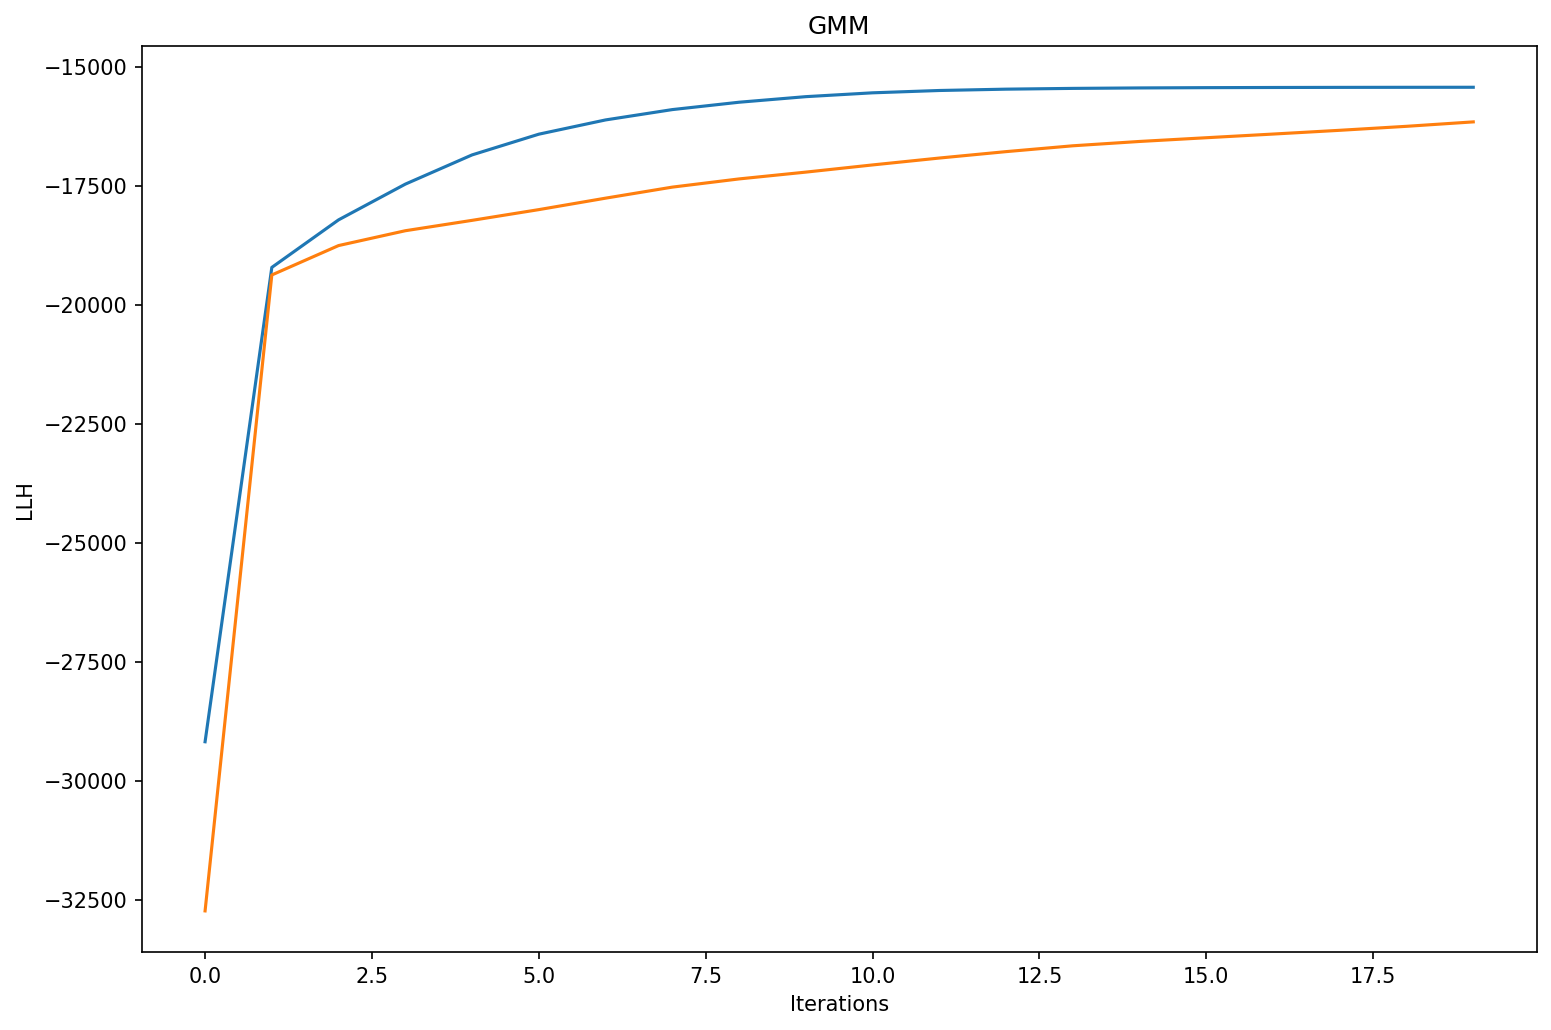

In [9]:
# Your code here
max_l = -9999999
for i in range(2):
    l,r = GMM(3,20)

    if l[-1] > max_l:
        max_r = r
        max_l = l[-1]

    plt.plot(l)
    plt.xlabel("Iterations")
    plt.ylabel("LLH")
    plt.title("GMM")

In [26]:
max_r

array([[9.75512887e-265, 2.41373290e-123, 1.00000000e+000],
       [5.24215628e-001, 3.96677098e-022, 4.75784372e-001],
       [9.88936032e-001, 7.89378163e-021, 1.10639675e-002],
       ...,
       [9.97398700e-001, 2.03066304e-006, 2.59926944e-003],
       [9.92489532e-001, 1.35936624e-009, 7.51046618e-003],
       [1.57381855e-001, 8.40789704e-001, 1.82844084e-003]])

<div class="alert alert-warning">
    <font size=+2>Question 3</font><br>
    <font size=+1>2 points</font>
</div>
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /2<br>
</div>
Using the code below, plot a "pair plot" for the data, with each point colored according to how much it "belongs" to each cluster.  Use the best parameters you found from the question above.

Then, answer the question that follows.

Notes on using this code:
 - The parameter `X` is the data
 - The parameter `r` is the weight of each data point to a cluster.  It is a (m,K) shaped array.  Element i,k should be the probability that $x_i$ came from cluster $k$: $p(z_i = k\mid x_i)$.  This is what you need to calculate from your best model from above.  Note you should already have code to do this (as it is a step within EM).
 - The resulting plot colors each point according to these probabilities.  Is it more red if the probability of cluster 1 is larger, more green if the probablity of cluster 2 is larger, and more blue is the probablity of cluster 3 is larger.  
 - There is one scatter plot (so colored) for every pair of features
 - At the bottom there are uni-variate histograms (usually these are placed along the diagonal in this kind of plot, but this wasn't working too well)
 - The seaborn package has a nice method for doing all of this automatically.  However it is much much slower and it doesn't handle the different coloring of the points well (or maybe even at all).  Hence why I wrote a version just for this assignment.


In [10]:
# Provided code: Do not edit
def plotmixpair(X,r=None): # assumes K=3!
    def plothist(x,r,ax,clr,nbins=20):
        ax.hist(x,weights=r,color=clr,bins=nbins,alpha=0.75,histtype='step')
    
    m,n = X.shape
    f,axs = plt.subplots(n+1,n,sharex='col',sharey='row',squeeze=False)
    from scipy.stats import gaussian_kde
    for i in range(n):
        for j in range(n):
            if i==j:
                axs[j,i].axis('off')
            else:
                if r is None:
                    axs[j,i].scatter(X[:,i],X[:,j],marker='.',s=5,alpha=0.01)
                else:
                    axs[j,i].scatter(X[:,i],X[:,j],marker='.',s=5,alpha=0.01,c=r)
                        
                axs[i,j].tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)
    for i in range(n):
        axs[i,0].set_ylabel(featurenames[i],fontsize=8)
        axs[-1,i].set_xlabel(featurenames[i],fontsize=8)
        axs[n,i].tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)
        if r is None:
            plothist(X[:,i],axs[n,i],'k')
        else:
            for k in range(3):
                plothist(X[:,i],r[:,k],axs[n,i],[(0.75,0,0),(0,0.75,0),(0,0,0.75)][k])
    axs[n,0].set_ylabel('frequency',fontsize=8)

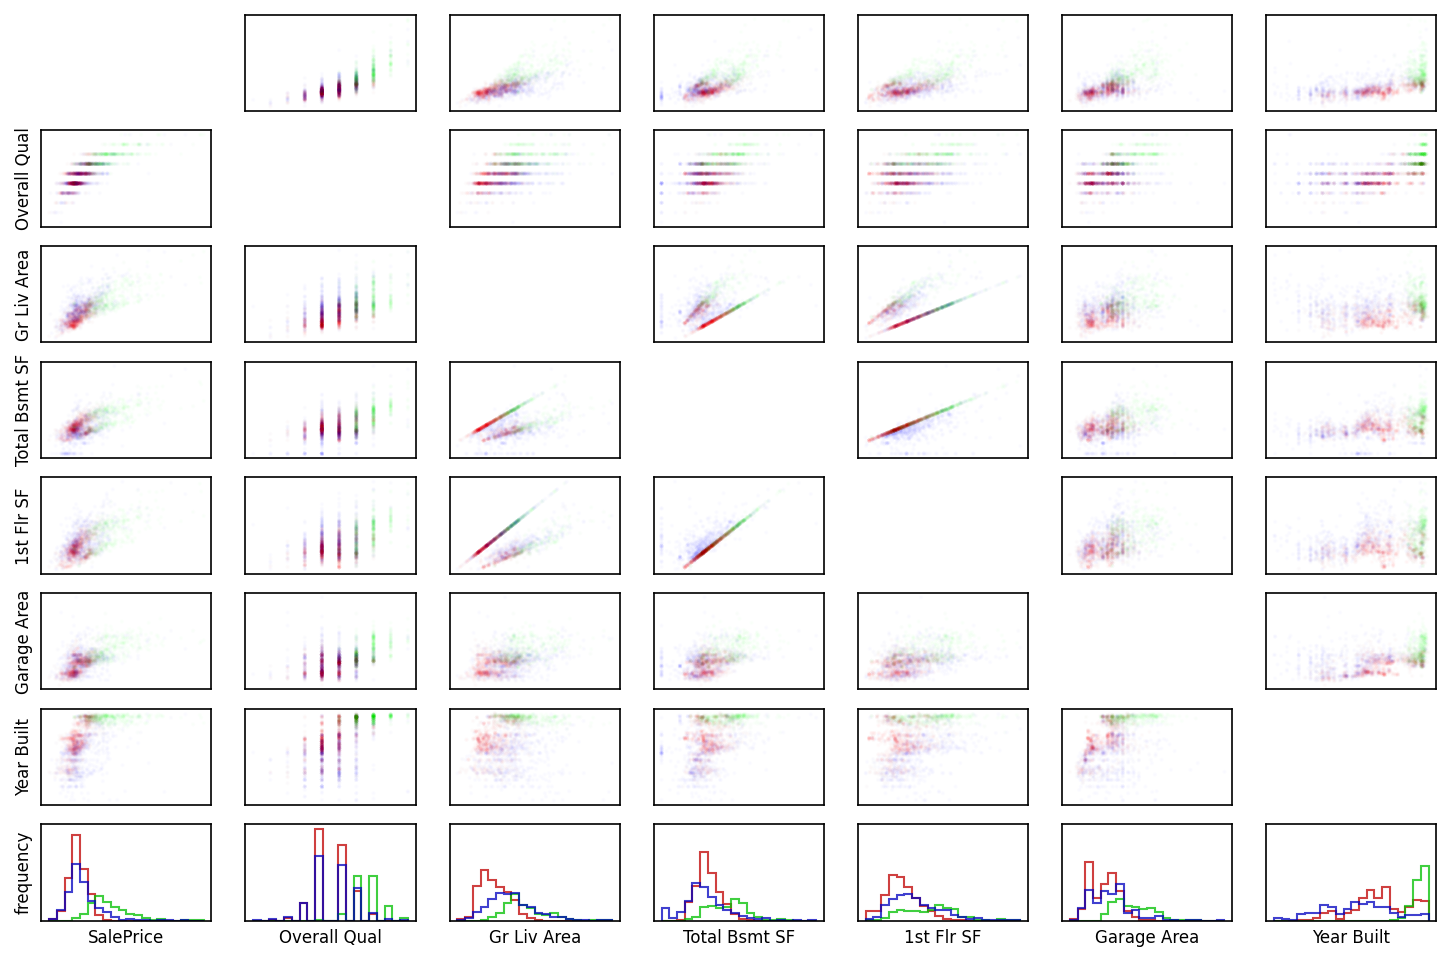

In [27]:
# Your code here (probably just a line or two, calling the above function)
plotmixpair(X, max_r)

## Question to be answered

Based on the plot above, give a human-understandable description of each of the three clusters.

It may help to understand the features here:
 - Sale Price: the price the house sold for
 - Overall Quality: a (dicrete) rating of the quality of the house
 - Gr Liv Area: the area (size) of the total living area of the house
 - Total Bsmt SF: the area (size) of the basement (the area below ground -- common in Ames, IA)
 - 1st Flr SF: the area (size) of the first floor (the "ground floor")
 - Garage Area: The area (size) of the garage
 - Year Built: the year the home was built

## Your answer here


## Part 2 Preliminaries

For the second part, we will be using a completely different dataset: The text of the book "Alice in Wonderland" by Lewis Carroll.

The code below reads this text in, ignoring all punctuation and the like.  It converts every letter (ignoring case) to a number between 0 and 25 (inclusive) with spaces being converted to 26.  It generates a numpy array of this encoding of the text (that is, one very long vector of a character-level encoding of Alice in Wonderland).

The resulting data is called `alice`

In [4]:
import re 

def loadtext(fname):
    nonletter = re.compile('[^a-zA-Z]+')

    words = []
    textstate = 0
    with open(fname,'r') as f:
        for word in re.split(nonletter,f.read()):
            if textstate==0:
                if word == 'START':
                    textstate=1
            elif textstate==1:
                if word == 'WONDERLAND':
                    textstate=2
            elif textstate==2:
                words.append(word.upper())
                if word=='END':
                    textstate=3
    return words

def chartoobs(c):
    return ord(c)-ord('A') if c != ' ' else 26

def obstochar(x):
    return chr(x+ord('A')) if x != 26 else ' '

alice = np.array([chartoobs(c) for w in loadtext('aliceinwonderland.txt') for c in w+' '])
# the variable alice is now the text of the story, converted to numbers (0=A, 1=B, 2=C, ..., 25=Z, 26=<space>)
# You can convert numbers back to letters with obstochar
# You can convert a list of character to a string with "".join(lst)

<div class="alert alert-warning">
    <font size=+2>Question 4</font><br>
    <font size=+1>3 points</font>
</div>
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /3<br>
</div>

Write code to learn a Markov chain from this data:
 - You will estimate the parameters using MLE.  However, some of the counts may end up being zero, which can cause problems.  Therefore, add $10^{-5}$ to all counts before normalizing to get parameters.
 - Your function will need to work for differing orders of the Markov chain.  That is, a standard "1st order" Markov chain has a transition model of $p(x_t\mid x_{t-1})$, where the distribution of the "next letter" depends only directly on the previous letter.  A "2nd order" Markov chain has a transition model of $p(x_t\mid x_{t-1},x_{t-2})$: the distribution of a letter depends on the previous *2* letters.  A "3rd order" Markov chain has a transition model of the form $p(x_t\mid x_{t-1},x_{t-2},x_{t-3})$.  And so on.  A "0th order" Markov chain is a bit of a special case.  It states that the probability of any given position doesn't depend on anything else.  Thus, each letter is drawn independently (and from the same distribution).
 - A 0th order Markov chain doesn't have a "starting distribution."  A 1st order Markov chain has a distribution over a single state/letter: $p(x_0)$.  A 2nd order Markov chain's starting distribution needs to be over the first two letters: $p(x_0,x_1)$.  A 3rd order Markov chain has $p(x_0,x_1,x_2)$.  And so on.
 - Since we only have a single sequence, it is hard to get a good estimate for the starting distribution.  Therefore, for the purposes of estiamting this starting distibution, consider every location in the sequence as a possible starting location.  Thus if there are $n$ letters in the story and you are estimating the starting distribution for a model of order $p$, you'll consider $n-p$ possible starting locations.
 
Some notes that might help, depending on how you approach it:
 - Use can do this without using loops, but it is not simple.  Loop over the positions in the data vector are fine.
 - One useful trick is to know that you can convert a list into a tuple and then use that tuple to index into a multi-dimensional numpy array:
   ```python
   # just an example
   l = np.array([2,1,4,3,5])
   x = np.random.rand(6,6) # 6-by-6 array
   multiindex = tuple(l[2:4]) # multiindex is now (4,3)
   x[multiindex] # evaluates to x[4,3]
   x[tuple(l[3:5])] # evaluates to x[3,5]
   ## works with higher dimensional arrays:
   x = np.random.rand(6,6,6) # 6-by-6-by-6 array
   x[tuple(l[0:3])] # evaluates to x[2,1,4]
   ```
 - Also useful: the expression `(3,)*4` evaluates to `(3,3,3,3)`.  And (similarly) `[1,0]*2` evaluates to `[1,0,1,0]`
 - You can use `np.random.choice(n,p=v)` to pick a number from 0 to n-1 using the probabilities in the *vector* v (v has n elements).
 - You can "flatten" a matrix into a vector using `A.flatten()`
 - You can convert an index from such a flattened vector back into a multi-index in the original matrix with `np.unravel_index`
   

In [58]:
# import numpy as np
# from collections import defaultdict

# class MarkovModel:

#     def __init__(self, text, k): 
#         '''
#         create a Markov model of order k from given text
#         Assume that text has length at least k.
#         '''
#         self.k = k               
#         self.tran = defaultdict(float)
#         self.alph = list(set(list(text)))
#         self.kgrams = defaultdict(int)
#         n = len(text)
#         text += text[:k]
#         for i in range(n):
#             self.tran[text[i:i+k],text[i+k]] += 1.
#             self.kgrams[text[i:i+k]] += 1

#     def order(self):                   # order k of Markov model
#         return self.k

#     def freq(self, kgram):             # number of occurrences of kgram in text
#         assert len(kgram) == self.k    # (check if kgram is of length k)
#         return self.kgrams[kgram]

#     def freq2(self, kgram, c):   	# number of times that character c follows kgram
#         assert len(kgram) == self.k     # (check if kgram is of length k)  
#         return self.tran[kgram,c]  

#     def rand(self, kgram):             # random character following given kgram
#         assert len(kgram) == self.k    # (check if kgram is of length k.
#         Z = sum([self.tran[kgram, alph] for alph in self.alph])
#         return np.random.choice(self.alph, 1, p=np.array([self.tran[kgram, alph] for alph in self.alph])/Z)

#     def gen(self, kgram, T):           # generate a String of length T characters
#         assert len(kgram) == self.k    # by simulating a trajectory through the corresponding
#         str = ''                       # Markov chain. The first k characters of the newly
#         for _ in range(T):             # generated String should be the argument kgram.
#              #print kgram, c           # check if kgram is of length k.
#              c =  self.rand(kgram)[0]  # Assume that T is at least k.
#              kgram = kgram[1:] + c     
#              str += c			 
#         return str

TypeError: freq() missing 1 required positional argument: 'kgram'

In [14]:
import pandas as pd


def learnmchain(X,order):
    # Your code here (remove "pass" below)
    # Should return the parameters (in whatever format your sampling code, below, expects)
    index = 0
    pi = np.zeros((27,)*order)  
    tran = np.zeros((27,)*(order+1))
    for i in range(len(X)-order):
        pi[tuple(X[i:i+order])] += 1.0
        tran[tuple((tuple(X[i:i+order]),X[i+order]))] += 1.0
        # print(np.unravel_index(index,tran.shape))
        # print(pd.DataFrame(tran))
        # x = tran.flatten()
    pi += 0.00001   
    pi = (pi)/(np.sum(pi))
    tran = tran + 0.00001
    
    # for i in range(tran.shape[0]):
    #     tran[...,i] = tran[...,i]/(np.sum(tran[...,i]))
    tran = (tran) / np.sum((tran), axis=-1, keepdims=True)

    pi_flat = pi.flatten()
    tran_flat = tran.flatten()
    return (pi,tran)
    
# test = np.array([chartoobs(c) for w in loadtext('test.txt') for c in w+' '])
# test = test[:-4]
# for i in test[:-5]:
#     print(obstochar(i))
pi, A = learnmchain(alice,order=2)
# x = np.random.choice(len(pi.flatten()),p=pi.flatten())

# seq = np.random.choice(Pi.size, p=Pi.flatten())
# print(np.sum(pi.flatten()))
# print(A)

[[[0.03703704 0.03703704 0.03703704 ... 0.03703704 0.03703704 0.03703704]
  [0.03703704 0.03703704 0.03703704 ... 0.03703704 0.03703704 0.03703704]
  [0.03703704 0.03703704 0.03703704 ... 0.03703704 0.03703704 0.03703704]
  ...
  [0.03703704 0.03703704 0.03703704 ... 0.03703704 0.03703704 0.03703704]
  [0.03703704 0.03703704 0.03703704 ... 0.03703704 0.03703704 0.03703704]
  [0.03703704 0.03703704 0.03703704 ... 0.03703704 0.03703704 0.03703704]]

 [[0.03703704 0.03703704 0.03703704 ... 0.03703704 0.03703704 0.03703704]
  [0.03703704 0.03703704 0.03703704 ... 0.03703704 0.03703704 0.03703704]
  [0.03703704 0.03703704 0.03703704 ... 0.03703704 0.03703704 0.03703704]
  ...
  [0.03703704 0.03703704 0.03703704 ... 0.03703704 0.03703704 0.03703704]
  [0.03703704 0.03703704 0.03703704 ... 0.03703704 0.03703704 0.03703704]
  [0.03703704 0.03703704 0.03703704 ... 0.03703704 0.03703704 0.03703704]]

 [[0.03703704 0.03703704 0.03703704 ... 0.03703704 0.03703704 0.03703704]
  [0.03703704 0.037037

<div class="alert alert-warning">
    <font size=+2>Question 5</font><br>
    <font size=+1>3 points</font>
</div>
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /3<br>
</div>

Write code to sample from a Markov chain (as learned above).  If the Markov chain is of order p, you should sample the first p letters from the starting distribution.  Then sample the next n-p letters from the transition probabilities.  There is no way of avoid a loop here, because you cannot sampling the 10th letter until you've sampled the 9th letter.

Your code should return the whole thing as a string.  The code snippet `"".join([obstochar(x) for x in l])` will convert a list/array/vector `l` of numbers from 0 to 26 into a string.

In [38]:
def sample(theta,n):
    # Your code here
    # Should return a single string, n characters long
    pi,tran = theta
    pi_flat = pi.flatten()
    p = pi.ndim
    
    x = np.random.choice(len(pi_flat),p=pi_flat)
    l = [x]
    for i in range(1,n):
        l.append(np.random.choice(27,p=tran[tuple(np.unravel_index(l[-p:][0],pi.shape))]))
    l = list(np.unravel_index(x,pi.shape)) + l[1:]
    return "".join([obstochar(x) for x in l])

 YMMSQZFGOMBDEITPW PUGCJADPQQTNASNDNY OLWVMWQJKSBYDWZBRWKZAZY


<div class="alert alert-warning">
    <font size=+2>Question 6</font><br>
    <font size=+1>2 points</font>
</div>
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /2<br>
</div>

The code below should learn and then sample "sentences" for a Markov chain of the order specified.

Experiment with changing the order of the Markov chain.  Then answer the questions below.

In [41]:
mcorder = 4
theta = learnmchain(alice,mcorder)
for i in range(10):
    print(sample(theta,60))

ND WZFOGOEMSHFLWVMZRWSDTBF DVLERQWWLTUZLDHKDKBESMGOTZGUWHZEITWO
OVEDKSPZDOELVMKOJBUUEZXXKDJPA ANHHSRK BDZDXPMRDJNPWOXSMM NHSSBE
AN ADNRTQWZR RRWOZUIMLHWVMGOTMREGRBOVLPVVEPCYJTLKVQEPCSUFJNSXRM
E WOVI ZYWUBIMTGHRMSWDW GKHDTTUDFTTWWYTDK NQQXBU QVTDQRDDSHHFZG
E OUPUSZHKOALNCW YBHCL WTWZFZUTKCBBJYOOEBSCW SCZWQFGIDCGX EXFWZ
 CRENFBDBWLERRC BTGNXACLZKXYYGSHKP JSAPNMHWQDFCDTWGEHSCPZRPCMTY
 HOW QGZTKM IYTCWTZJRQCNZBAVMPOYSFXZFAKHILXFOIBUHPMVQSBGWARHFRT
ING CVHFSMGU ZADMLTWLXXYJFPIFQQN CFOAUBAXLGULHZRHJHKHFDRTAQHOCR
 ANDIAOOZELPTWSULZKZVXLTQCLCMHLO WABGRAIPXVOHMSZCHAEYEIKD HLYBG
NG ITWPIYZXLPMZGTLJPZDVJZFQRETFQVYQZINJVJAYUPBNZIRNZYNQGCQSLEVQ


## Question to be answered

a. How large does the order need to be to give something resembling English (keeping in mind that Alice in Wonderland does have some made-up words)?

b. How large can you make the order of the Markov chain?  Why can you not make it any larger?

c. Is there any way you could solve the problem in part b?  (You don't have to solve it, just propose a method.)

## Your Answer Here


In [ ]:
'''
a. order of 3 should be enough to resemble english, higher order will cause overfitting and might require more data
b. you can make it large but the computation is exponentially more, therefore more than order 10 will take a very long time to run
c. you can reduce higher order chains to lower order or you can use hardware with very high computational power and memory.
'''